# 1. Importing libraries and web scraping

In [1]:
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import seaborn as sns
import pandas as pd
import requests
import re 

In [2]:
headers = {
    'User-Agent': 'Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.64 Safari/537.36',
    'Accept-Language': 'en-US, en;q=0.5'
}
car_results = []


In [3]:
# Loop through pages 1 to 10
for page_number in range(1,10):
    url = f'https://turbo.az/autos?page={page_number}'
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    for el in soup.find_all('div', {'class' : 'products-i__bottom'}):
        
        car_results.append({
        'name' : el.find('div', {'class': 'products-i__name products-i__bottom-text'}).text,
        'price' : el.find('div',{'class':'products-i__price products-i__bottom-text'}).text.strip(),
        'currency' : el.find('div',{'class':'products-i__price products-i__bottom-text'}).text.replace(' ','').strip()[-1],
        'price' : el.find('div',{'class':'products-i__price products-i__bottom-text'}).text.replace(' ','').strip()[:-1],
        'year' : el.find('div', {'class': 'products-i__attributes products-i__bottom-text'}).text.split(',')[0].strip(),
        'engine_power' : el.find('div', {'class': 'products-i__attributes products-i__bottom-text'}).text.split(',')[1].strip(),
        'km' : el.find('div', {'class': 'products-i__attributes products-i__bottom-text'}).text.split(',')[2].strip()
        })
        
# Create DataFrame from the collected results
cars = pd.DataFrame(car_results)

In [4]:
cars.head()

,name,price,currency,year,engine_power,km
0,Land Rover Range Rover,98000,$,2018,3.0 L,35 000 km
1,Volkswagen ID.6,39999,$,2023,0.0 L,0 km
2,Land Rover RR Sport,165000,$,2023,3.0 L,0 km
3,Land Rover Range Rover,122000,$,2019,5.0 L,47 000 km
4,Toyota Land Cruiser,26500AZ,N,2001,4.2 L,452 000 km


In [5]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          324 non-null    object
 1   price         324 non-null    object
 2   currency      324 non-null    object
 3   year          324 non-null    object
 4   engine_power  324 non-null    object
 5   km            324 non-null    object
dtypes: object(6)
memory usage: 15.3+ KB


# 2. Data Cleaning

In [6]:
# 1. In the 'price' column, replace 'AZ' and split
cars['price'] = cars['price'].str.replace('AZ', '').astype(int)

# 2. In the 'currency' column, replace 'N' with ₼
cars['currency'] = cars['currency'].replace('N', '₼')

# 3. In the 'engine_power' column, replace '2.0 L' format and remove 'L'
cars['engine_power'] = cars['engine_power'].replace({'L': ''}, regex=True)

# 4. In the 'km' column, remove 'km' from all rows
cars['km'] = cars['km'].str.replace('km', '')

In [7]:
# Define conversion factors
currency_conversion_factors = {'₼': 1, '$': 1.7, '€': 1.83}

# Create a new column 'price_azn' by converting 'price' based on 'currency'
cars['price_azn'] = cars.apply(lambda row: row['price'] * currency_conversion_factors.get(row['currency'], 1), axis=1)

In [8]:
# Remove the 'price' and 'currency' columns
cars = cars.drop(['price', 'currency'], axis=1)

In [9]:
# Modify 'year' column
# Assuming 'year' column contains years in string format
cars['year'] = cars['year'].astype(int)
cars['engine_power'] = cars['engine_power'].astype(float)

In [10]:
# Multiply 'engine_power' column by 1000 and rename it to 'engine_power (cm3)'
cars['engine_power (cm3)'] = (cars['engine_power'] * 1000).astype(int)
cars = cars.drop('engine_power', axis=1)

In [11]:
cars.head()

,name,year,km,price_azn,engine_power (cm3)
0,Land Rover Range Rover,2018,35 000,166600.0,3000
1,Volkswagen ID.6,2023,0,67998.3,0
2,Land Rover RR Sport,2023,0,280500.0,3000
3,Land Rover Range Rover,2019,47 000,207400.0,5000
4,Toyota Land Cruiser,2001,452 000,26500.0,4200


# 3. Data Visualization

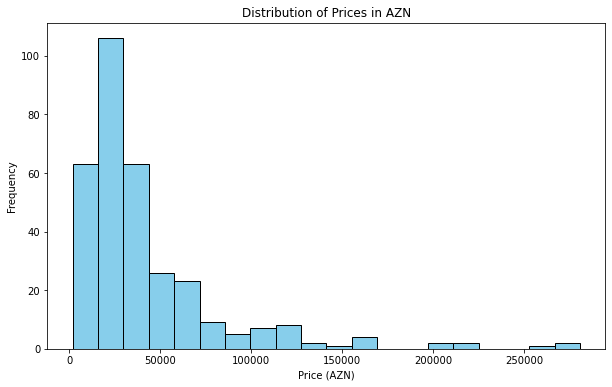

In [12]:
# Histogram of 'price_azn' column
plt.figure(figsize=(10, 6))
plt.hist(cars['price_azn'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Prices in AZN')
plt.xlabel('Price (AZN)')
plt.ylabel('Frequency')
plt.show()

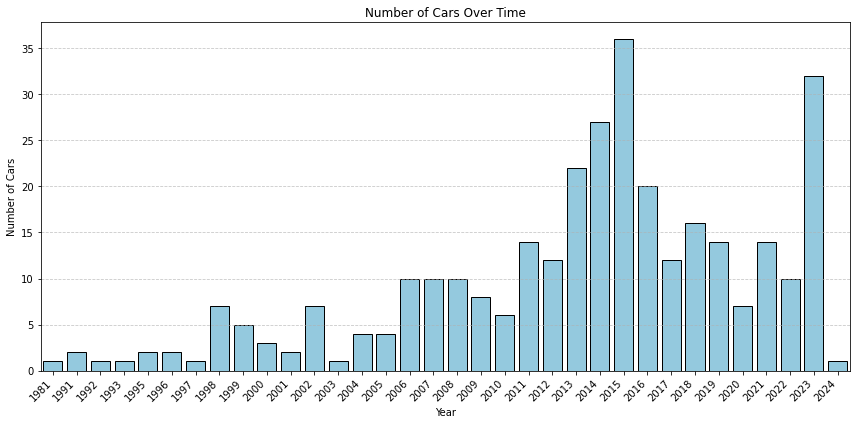

In [13]:
# Group by 'year' and count the number of cars in each year
car_count_by_year = cars['year'].value_counts().sort_index()

# Bar chart of car count by year with enhanced visualization
plt.figure(figsize=(12, 6))
sns.barplot(x=car_count_by_year.index, y=car_count_by_year.values, color='skyblue', edgecolor='black')
plt.title('Number of Cars Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Cars')
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7, which='both')
plt.tight_layout() 
plt.show()

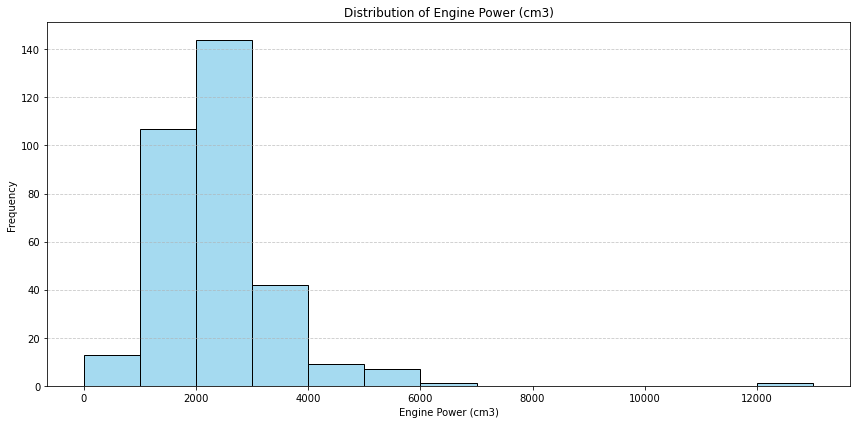

In [14]:
# Create bins for 'engine_power (cm3)'
bins = [i for i in range(0, int(cars['engine_power (cm3)'].max()) + 1000, 1000)]

# Histogram of 'engine_power (cm3)'
plt.figure(figsize=(12, 6))
sns.histplot(cars['engine_power (cm3)'], bins=bins, color='skyblue', edgecolor='black', kde=False)
plt.title('Distribution of Engine Power (cm3)')
plt.xlabel('Engine Power (cm3)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()